# esabin: a ham radio example
*This example is inspired by ([HAMSci](http://www.hamsci.org)), a community of professional and citizen scientists using amateur radio signals (which travel great distances by reflecting off the ionosphere) to better understand the ionosphere and the space weather that affects it*

The [Weak Signal Propagation Reporter (WSPR) Network](https://www.wsprnet.org/drupal/) is a tool used by amateur (ham) radio enthusiasts to determine how far away their radio broadcasts can be heard. The WSPR protocol is a digital signal which encodes the transmitter's location, so that any station that recieves it can identify the source and the distance the signal has traveled. For some frequency ranges (bands) that distance can be halfway across the world! Each reception of a particular transmitter's signal is called a 'spot', and the WSPR Network records each 'spot' in a publically accessible database. We will use this database in the following example of the esabin library.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load a few days of 'spots' for one transmitter (DK2DB) on one band (40 meters)
This data was selected using one of the CSVs available from [the WSPR network website](https://www.wsprnet.org/drupal/downloads). This transmitter and band were picked because they had the overall largest number of total spots in November of 2021.

The 40m band (frequency ~ 7 MHz) is arguably the most popular frequency for amateur radio, especially for long-distance (DX) communication
 

In [2]:
df = pd.read_csv('wspr_2021-11_DK2DB_band_7.csv')
df['time']=pd.to_datetime(df['timestamp'],unit='s') #convert unix time to datetime
df.set_index('time',inplace=True)
df.columns

Index(['id', 'timestamp', 'reporter', 'reporter_grid', 'snr', 'frequency',
       'callsign', 'grid', 'power', 'drift', 'distance', 'azimuth', 'band',
       'version', 'code'],
      dtype='object')

# Find locations of each recieving station
The ham radio community uses a location system call '[Maidenhead](https://en.wikipedia.org/wiki/Maidenhead_Locator_System)' which divides the surface of the planet into a grid and labels each grid cell with a alphanumeric string. We need to convert this to latitude and longitude (using the open source Python maidenhead library)

In [3]:
#Find the locations in latitude and longitude of each report
import maidenhead as mh
lats,lons = [],[]
for i in range(len(df.index)):
    thisdata = df.iloc[i]
    lat,lon = mh.to_location(thisdata['reporter_grid'])
    lats.append(lat)
    lons.append(lon)
df['reporter_lat']=lats
df['reporter_lon']=lons
#Find the location of the transmitter
transmitter_lat,transmitter_lon = mh.to_location(df.iloc[0]['grid'])

# Calculate the local time at which each signal was recieived
To demonstrate the local time binning feature of `esabin`, and also demonstrate how 7 MHz signal propagation is affected by whether the ionosphere is sunlit or dark, we need to know what the time was *at the location of the recieiver* when each 'spot' occured. If the time is 18-24 or 0-6 we will know it was night for the spotter.

In [4]:
from geospacepy.sun import local_mean_solar_time
from geospacepy.special_datetime import datetimearr2jd
dts = df.index.to_pydatetime()
jds = datetimearr2jd(dts)
slt=local_mean_solar_time(jds,df['reporter_lon'].values)/np.pi*12. #Returns answer in radians, convert to hours
slt[slt<0]+=24 #Make sure there are no negative times
df['reporter_local_time']=slt

# Let's look at the raw data
We can use the [cartopy](https://github.com/SciTools/cartopy) library to plot the location of all of the spots on a map.

We will color the spots by the signal-to-noise ratio (the signal strength at the receiver). The transmitter is in Europe, and there are spots all across the globe

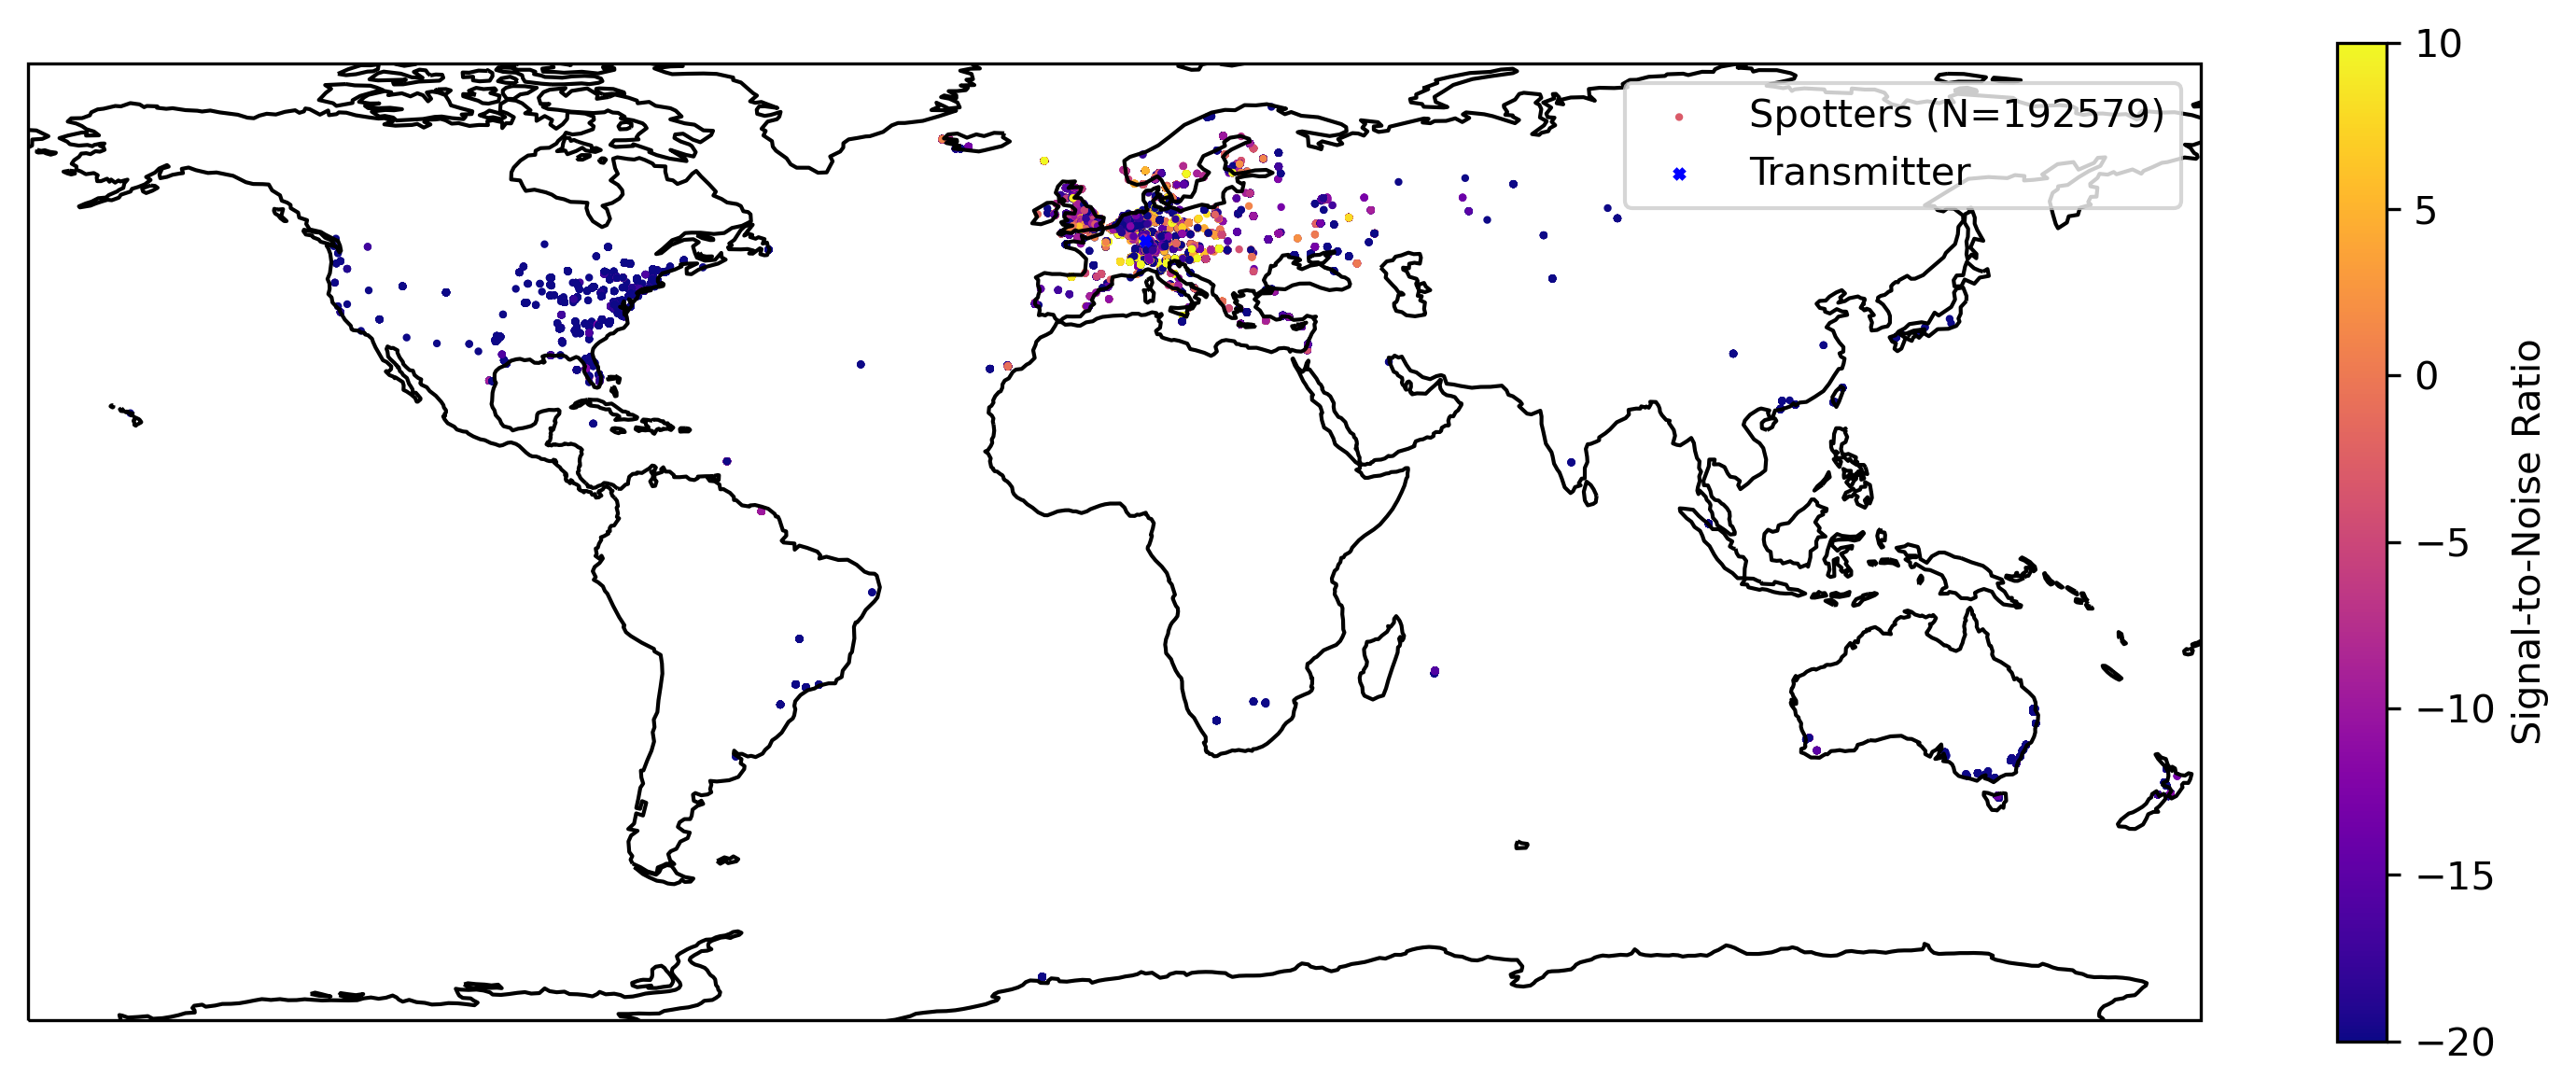

In [5]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import datetime

azeqkwargs = {'central_longitude':0.0,         
            'false_easting':0.0, 
            'false_northing':0.0,
            'globe':None}

projection_map = ccrs.PlateCarree()
projection_polar = ccrs.AzimuthalEquidistant(central_latitude=90.0,**azeqkwargs)
transform = ccrs.PlateCarree()

fmap = plt.figure(figsize=(10,4),dpi=300)
axmap = fmap.add_subplot(111,projection=projection_map)
axmap.coastlines()
mappable = axmap.scatter(df['reporter_lon'],df['reporter_lat'],1,df['snr'],cmap='plasma',vmin=-20,vmax=10,label=f'Spotters (N={df.index.size})')
axmap.scatter(transmitter_lon,transmitter_lat,6,'b',marker='x',label='Transmitter')
axmap.legend()
fmap.colorbar(mappable,label='Signal-to-Noise Ratio')
fmap.tight_layout()

/home/liamk/anaconda3/envs/esabin_notebooks/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:842: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/liamk/anaconda3/envs/esabin_notebooks/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:848: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
/home/liamk/anaconda3/envs/esabin_notebooks/lib/python3.10/site-packages/numpy/lib/function_base.py:5392: ShapelyDe

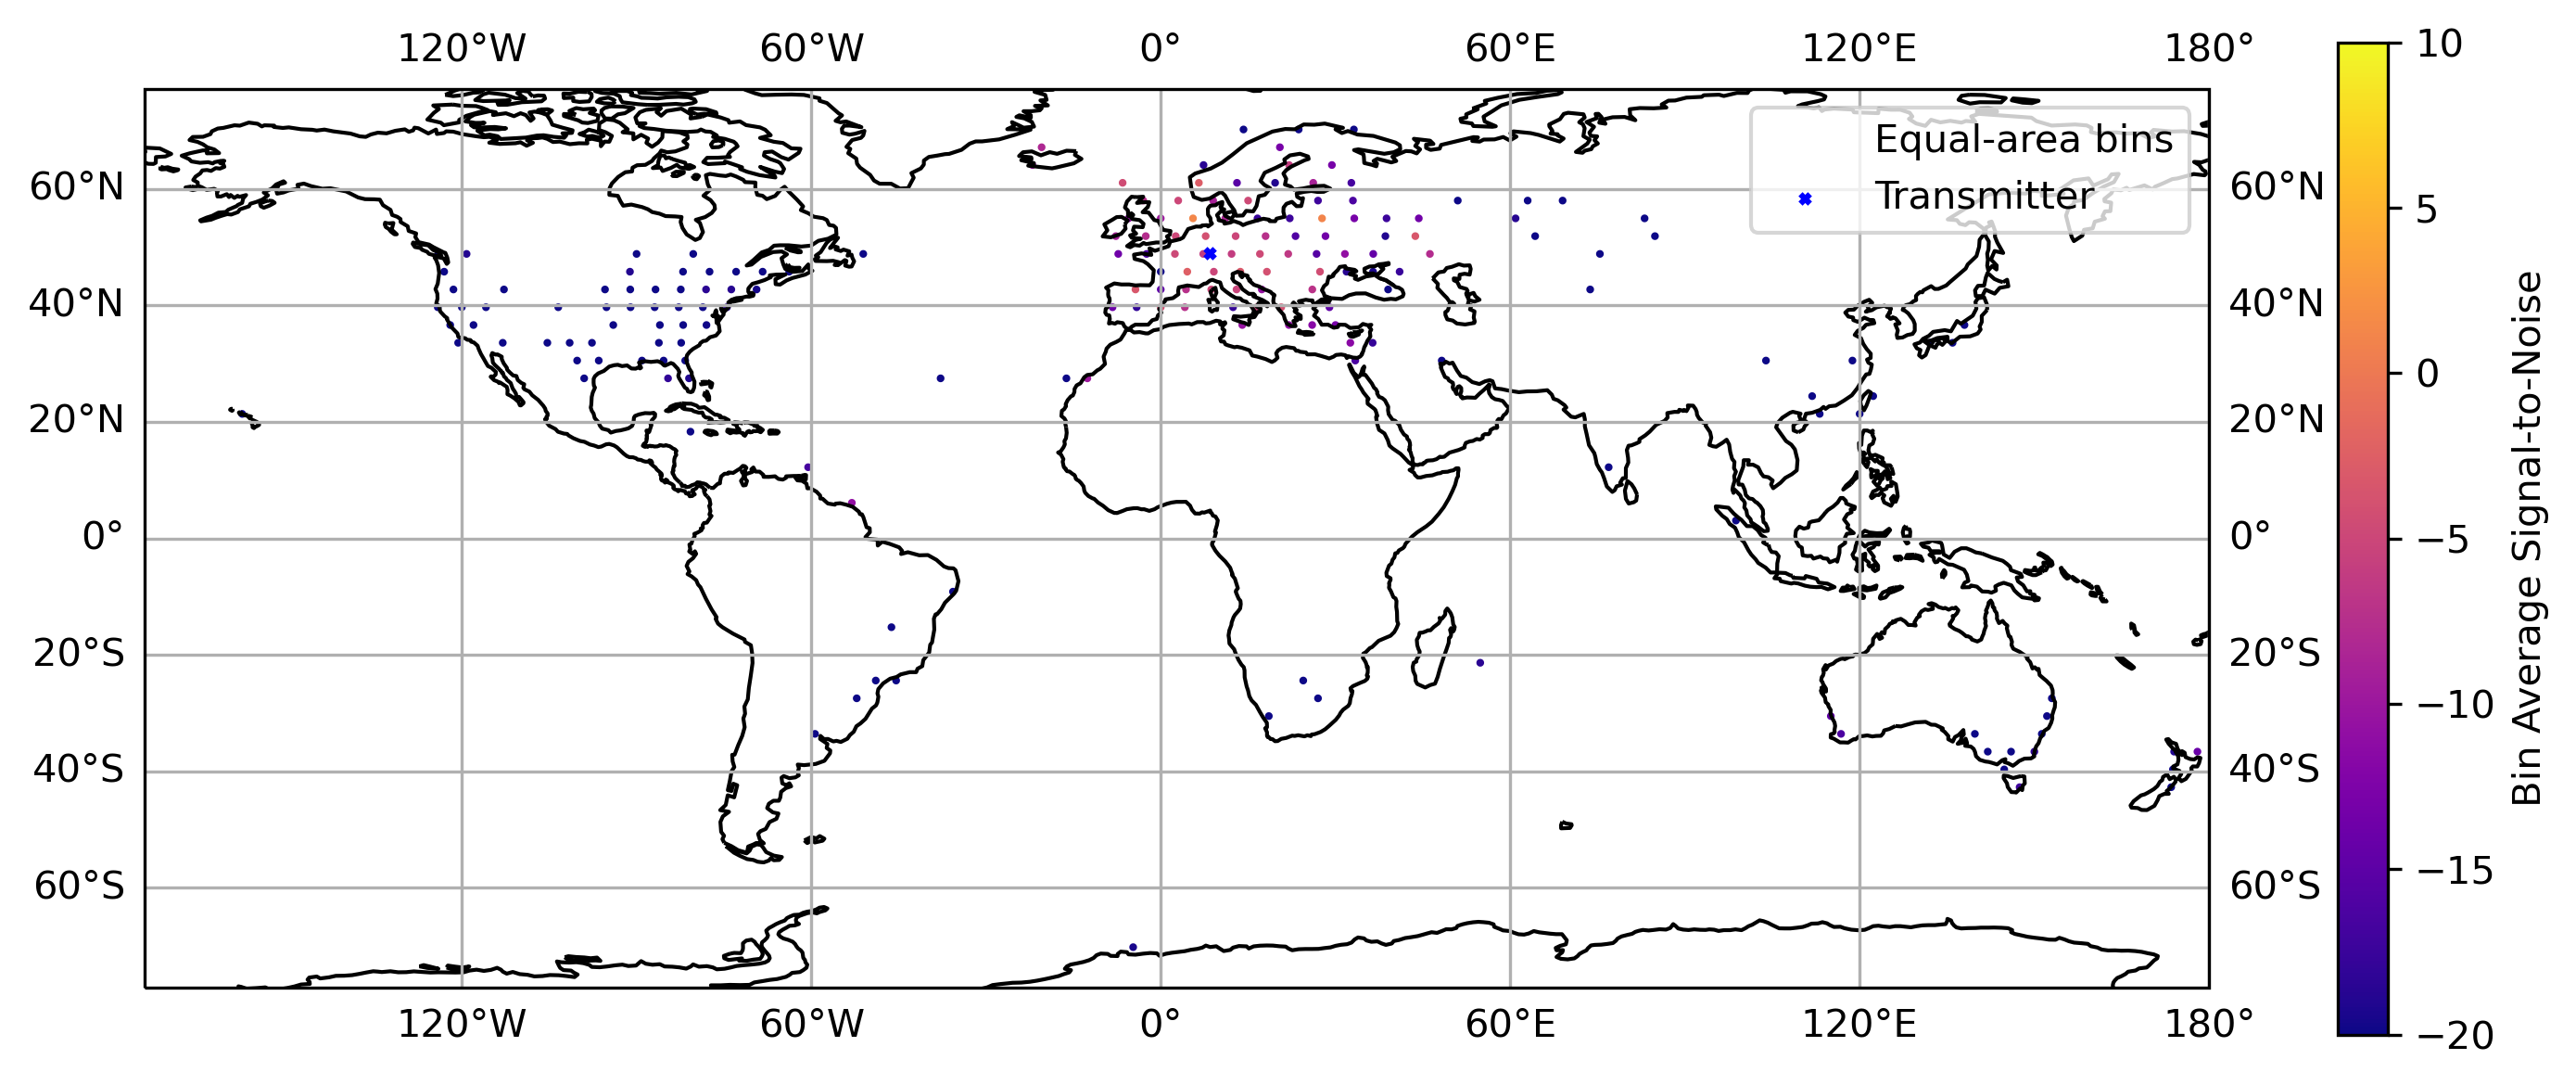

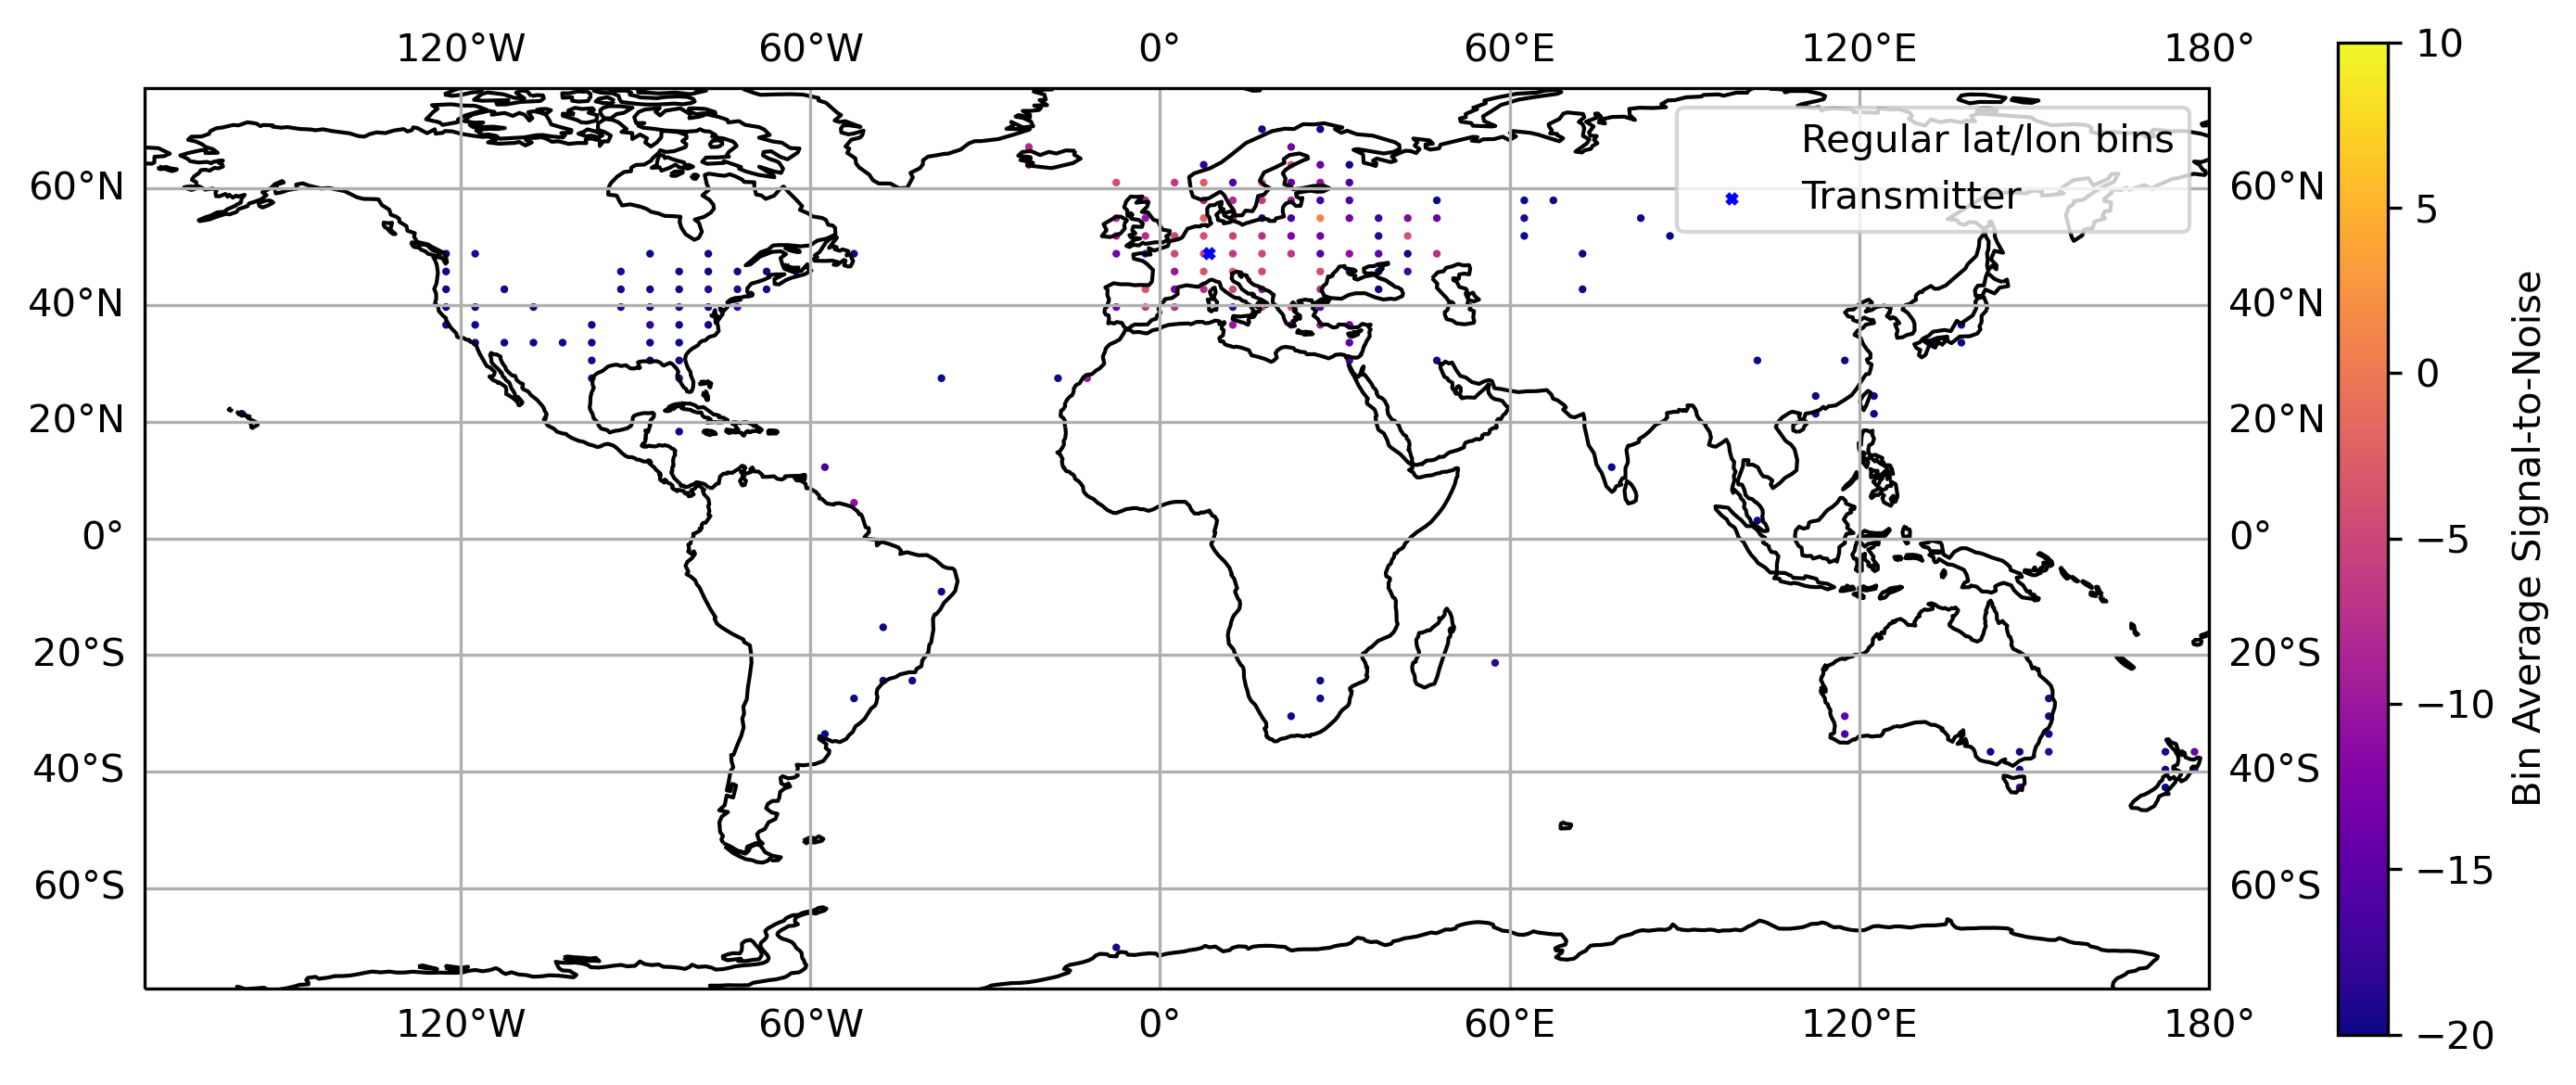

In [6]:
#Equal Area Bins
from esabin.esagrid import Esagrid
esagrid_lon = Esagrid(delta_lat=3,n_cap_bins=3,azi_coord='lon')
ebin_lats,ebin_lons,ebin_mean_snr = esagrid_lon.bin_stats(df['reporter_lat'].values,
                                                       df['reporter_lon'].values,
                                                       df['snr'].values,
                                                       center_or_edges='center')
#Standard Lat/Lon Bins
from esabin.esagrid import ConstantAzimuthalSpacingGrid
rectgrid_lon = ConstantAzimuthalSpacingGrid(delta_lat=3,delta_azi=5,azi_coord='lon')
rbin_lats,rbin_lons,rbin_mean_snr = rectgrid_lon.bin_stats(df['reporter_lat'].values,
                                                       df['reporter_lon'].values,
                                                       df['snr'].values,
                                                       center_or_edges='center')

for bin_lats,bin_lons,bin_mean,bin_kind in [(ebin_lats,ebin_lons,ebin_mean_snr,'equal-area bins'),
                                            (rbin_lats,rbin_lons,rbin_mean_snr,'regular lat/lon bins')]:
    fmap = plt.figure(figsize=(10,4),dpi=300)
    axmap = fmap.add_subplot(111,projection=projection_map)
    axmap.coastlines()
    mappable = axmap.scatter(bin_lons,bin_lats,1,bin_mean,cmap='plasma',vmin=-20,vmax=10,label=bin_kind.capitalize())
    axmap.scatter(transmitter_lon,transmitter_lat,6,'b',marker='x',label='Transmitter')
    axmap.legend()
    axmap.gridlines(draw_labels=True)
    fmap.colorbar(mappable,label='Bin Average Signal-to-Noise')
    fmap.tight_layout()

# Let's examine how the SNR changes over time for one bin
We can filter the data by spots which were more than 4000 km from the transmitter to see how cross-continental propagation changed

In [7]:
#The third output of the `whichbin` function is the number of the bin into which each value in the lat/lon arrays falls
latbinind,lonbandind,flatind = esagrid_lon.whichbin(df['reporter_lat'].values,df['reporter_lon'].values)
df['esabin_number'] = flatind

#First let's find out where bins are
bin_lats,bin_lons = esagrid_lon.bin_locations(center_or_edges='center')

#Look at how SNR changes for nearby recievers
nearbin_spot_counts = df[df['distance']>500]['esabin_number'].value_counts()
inearbin = nearbin_spot_counts.argmax() #Find index of bin with most spots
nearbin = nearbin_spot_counts.index[inearbin]
nearbin_counts = nearbin_spot_counts.iloc[inearbin]#Number of spots for that bin
nearbin_lat,nearbin_lon = bin_lats[nearbin],bin_lons[nearbin]

print(f'Bin {nearbin} at lat:{nearbin_lat:.1f},lon:{nearbin_lon:.1f} had {nearbin_counts} spots')

#Let's find out which bin at a reasonable distance from the transmitter had the most spots
farbin_spot_counts = df[df['distance']>4000]['esabin_number'].value_counts()
ifarbin = farbin_spot_counts.argmax() #Find index of bin with most spots
farbin = farbin_spot_counts.index[ifarbin]
farbin_counts = farbin_spot_counts.iloc[ifarbin]#Number of spots for that bin
farbin_lat,farbin_lon = bin_lats[farbin],bin_lons[farbin]

print(f'Bin {farbin} at lat:{farbin_lat:.1f},lon:{farbin_lon:.1f} had {farbin_counts} spots')


Bin 3784 at lat:51.9,lon:-2.6 had 22937 spots
Bin 3452 at lat:39.7,lon:-74.5 had 2352 spots


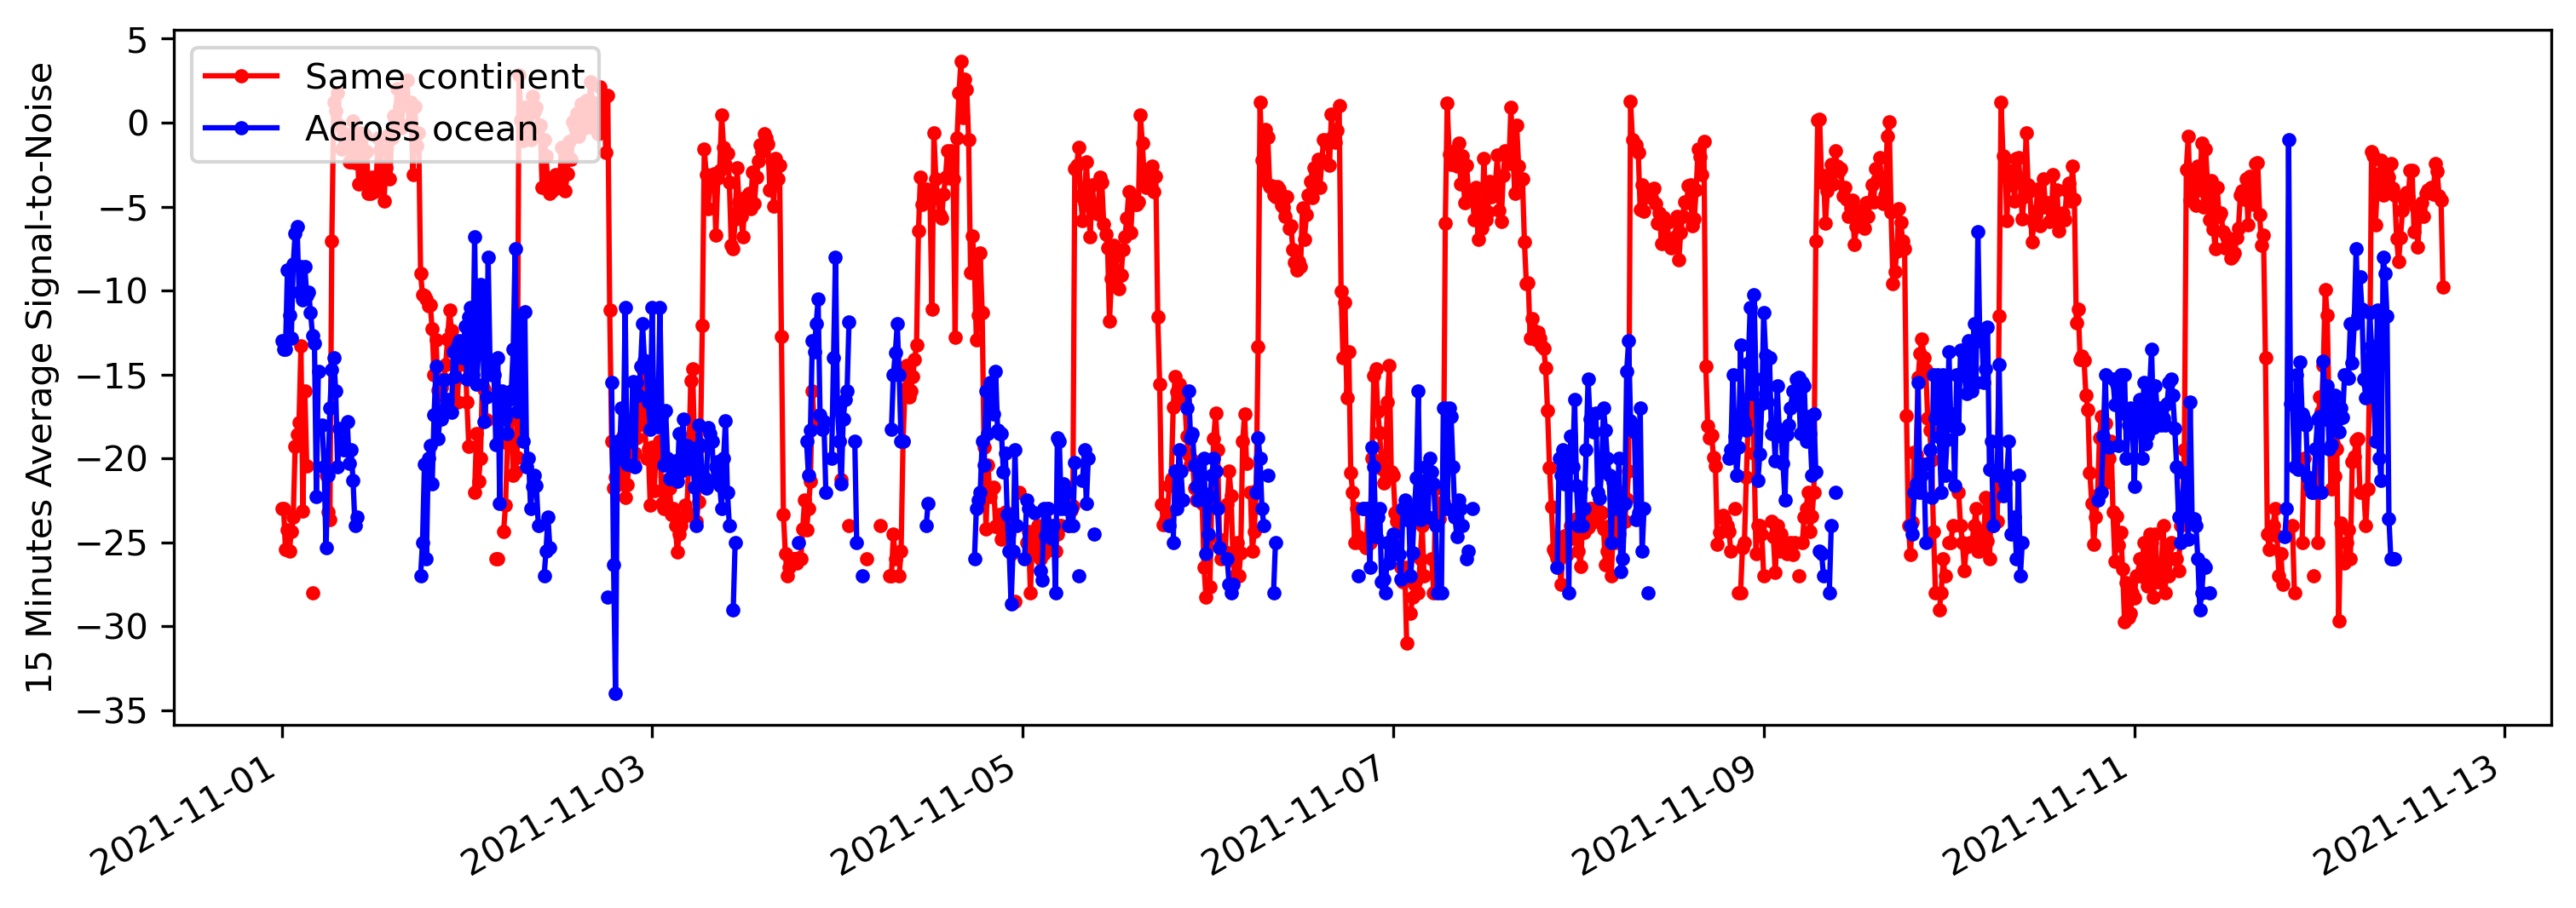

In [8]:
nearbin_df = df[df['esabin_number']==nearbin].resample('15T').mean()
farbin_df = df[df['esabin_number']==farbin].resample('15T').mean()

f1 = plt.figure(figsize=(12,4),dpi=300)
ax1 = f1.add_subplot(111)
ax1.plot(nearbin_df.index,nearbin_df['snr'],'r.-',label='Same continent')
ax1.plot(farbin_df.index,farbin_df['snr'],'b.-',label='Across ocean')
ax1.set_ylabel('15 Minutes Average Signal-to-Noise')
ax1.legend(loc='upper left')

f1.autofmt_xdate()
plt.show()

# Binning using local time
`esabin` can also bin data using azimuthal coordinates other than longitude, namely local time. When the spot data is binned in local time, it is easy to see that reception is best nearby to the transmitter (in the northern hemisphere) during daylight, but only reaches the southern hemisphere transmitters in darkness.

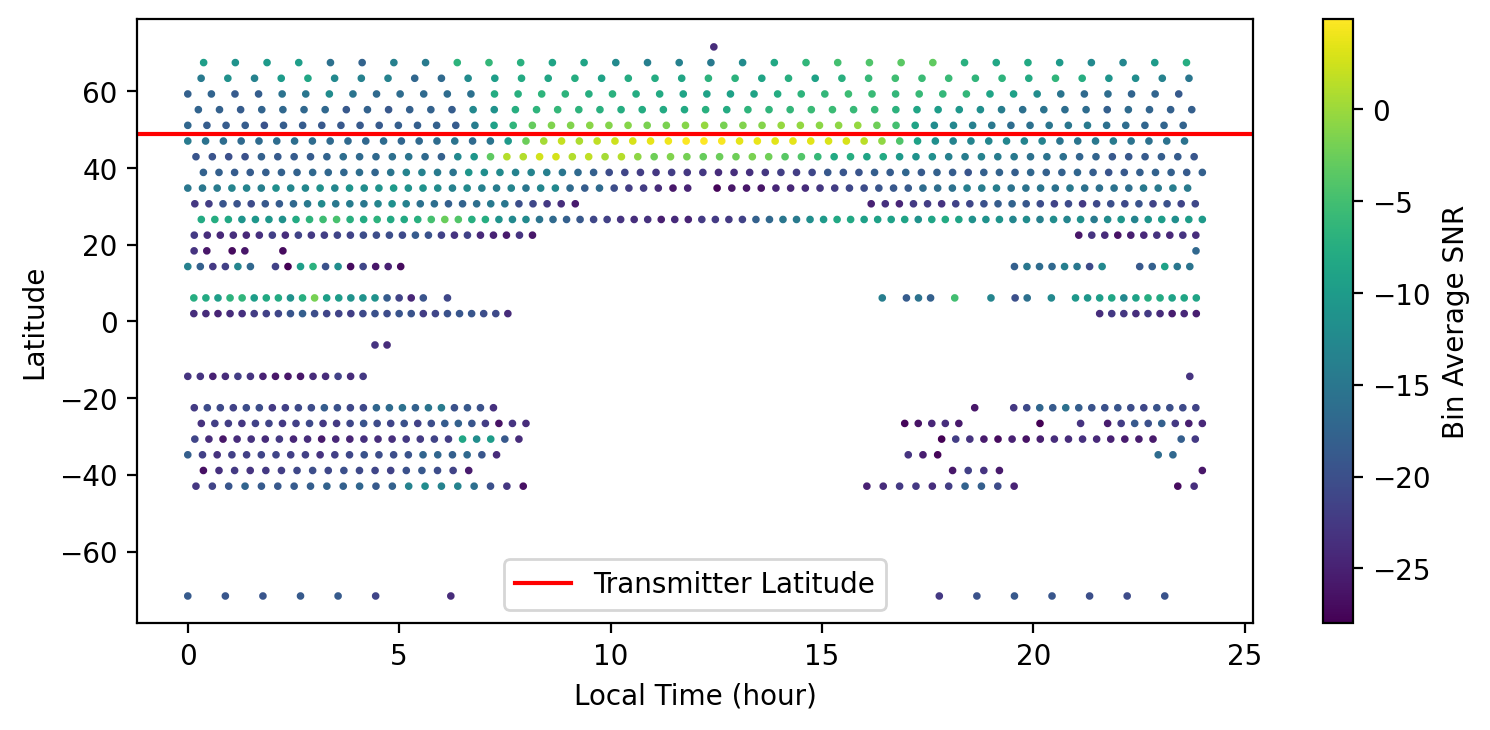

In [9]:
esagrid_lt = Esagrid(delta_lat=4,n_cap_bins=3,azi_coord='lt')
bin_lats,bin_lts,bin_mean_snr = esagrid_lt.bin_stats(df['reporter_lat'].values,
                                                       df['reporter_local_time'].values,
                                                       df['snr'].values,
                                                       center_or_edges='center')
bin_lts[bin_lts<0]+=24.

f=plt.figure(figsize=(9,4),dpi=200)
ax=f.add_subplot(111)
mappable = ax.scatter(bin_lts,bin_lats,3,bin_mean_snr)
ax.set_ylabel('Latitude')
ax.set_xlabel('Local Time (hour)')
ax.axhline(transmitter_lat,color='red',label='Transmitter Latitude')
ax.legend()
f.colorbar(mappable,label='Bin Average SNR')